# Classification for identifying abnormal instances

***
**Contest:** 2023년 지질자원 데이터 활용 및 인공지능 경진대회 (link [here](http://www.geodata-con.kr/2023/overview.php)).
**Original:** <i><b>A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells</i></b> published in the <i><b>Journal of Petroleum Science and Engineering</i></b> (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).
**Editor:** Jongwook Kim, Dogyun Kim
**Advisor:** Jonggeun Choe
**Last updated:** 07-05-2023
***

# 1. Strategy

#### 1. Load datasets
- <b>get filenames</b>: First of all, we need to get all the filenames we used.
- <b>load datasets</b>: Datasets will be loaded from csv files using pandas package. And merge all the datasets to unified dataset.
#### 2. Pre-processing - column scale
- <b>Response variables selection</b> We need to check which variables could be helpful in our analysis. Response variables had small size & variance will be dropped.
- <b>Logical treshold</b> will be applied at the dataset we used. It means non-logical values of the pressure (minus values) will be discarded and hard-outlier will also be eliminated. The thresholds are determined by conducting EDA.
- <b></b>

# 2. Imports and Configurations

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
import pickle

import sys
sys.path.append('stac')
from matplotlib import pyplot as plt
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from argparse import ArgumentParser
from module import *
from tqdm import tqdm_notebook as tqdm
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'png'

C:\Users\jongwook\miniconda3\envs\pytorch_gpu\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


#### <b>분석을 위한 초기변수 설정

In [2]:
data_path = Path('data')
random_state = 1
n_jobs = None
clfs = {'Decision Tree':     DecisionTreeClassifier(random_state=random_state),
        'AdaBoost':          AdaBoostClassifier(random_state=random_state),
        'Random Forest':     RandomForestClassifier(n_jobs=n_jobs, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']

#parsing the parameters
args = ArgumentParser()
args.columns = ['timestamp'] + vars + ['class']
args.normal_class_code = 0
args.undesirable_event_code = 1      # Undesirable event of interest
abnormal_classes_codes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
downsample_rate = 60            # Adjusts frequency of sampling to the dynamics
                                # of the undesirable event of interest
args.sample_size_default = 60        # In observations (after downsample)
args.sample_size_normal_period = 5   # In observations (after downsample)
args.max_samples_per_period = 15     # Limitation for safety
max_nan_percent = 0.15           # For selection of useful variables
std_vars_min = 0.01             # For selection of useful variables
disable_progressbar = True      # For less output

#### Get filenames & check num. of instances

In [3]:
# Gets all real instances but maintains only those with any type of undesirable event
#real_instances = get_instances_with_undesirable_event(data_path, args.undesirable_event_code,real=True,simulated=False, drawn=False)
real_instances = pd.DataFrame(class_and_file_generator(data_path,real=True,simulated=False,drawn=False),columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)
sim_instances = pd.DataFrame(class_and_file_generator(data_path,real=False,simulated=True,drawn=False),columns=['class_code', 'instance_path'])
sim_instances = sim_instances.loc[sim_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)
drawn_instances = pd.DataFrame(class_and_file_generator(data_path,real=False,simulated=False,drawn=True),columns=['class_code', 'instance_path'])
drawn_instances = drawn_instances.loc[drawn_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)
instances = pd.concat([real_instances, sim_instances, drawn_instances]).reset_index(drop=True)
print(f"number of total instances = {len(real_instances)+ len(sim_instances) + len(drawn_instances)}")
print(f"number of real instances = {len(real_instances)}")
print(f"number of simulated instances = {len(sim_instances)}")
print(f"number of drawn instances = {len(drawn_instances)}")

number of total instances = 1984
number of real instances = 1025
number of simulated instances = 939
number of drawn instances = 20


#### load datasets & merge

In [4]:
# Loads all real, simulated and drawn instances and applies downsample
instance_id = 0
df_real_instances, instance_id  = load_and_downsample_instances(real_instances, downsample_rate, 'real', instance_id,args)
df_simul_instances, instance_id = load_and_downsample_instances(sim_instances,downsample_rate,'simulated', instance_id,args)
df_drawn_instances, instance_id = load_and_downsample_instances(drawn_instances,downsample_rate,'drawn',instance_id, args)
df_instances = pd.concat([df_real_instances, df_simul_instances, df_drawn_instances])

## Preprocess step

#### 1. Response variables selection
앞서 설정한 허용가능한 nan 비율을 넘어서는 경우, 해당 변수를 drop

In [68]:
idxs = (df_instances['source']=='real') & (df_instances['instance_id'])
good_vars = np.isnan(df_instances.loc[idxs][vars]).mean(0) <= max_nan_percent
good_vars = list(good_vars.index[good_vars])
bad_vars = list(set(vars)-set(good_vars))
df_instances_good_vars = df_instances.drop(columns=bad_vars, errors='ignore')
print(good_vars)

['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']


#### 2. Logical threshold
EDA 과정에서 도출된 logical threshold를 이용하여 물리적인 범위를 벗어난 값을 지니는 instance를 제거
<i><b>Q. 일부만 이상치인 instance도 있을 건데 왜 전부 없애죠?</i></b>
 A. Logical threshold로 데이터를 가공하는 경우, 33개의 instance 내 데이터가 완전히 drop되고, 4개의 instance 내의 데이터는 일부만 drop되게 됨.
 문제는, 해당 4개의 instance의 자료가 비정상적이었음. 따라서, 해당 instance도 완전히 제외

In [69]:
df_instances_logical = logical_threshold(df_instances_good_vars)

In [71]:
# Totally eliminated
elim_set_total = set(df_instances_good_vars['instance_id']) - set(df_instances_logical['instance_id'])
# Partially eliminated
loss = {}
for id in sorted(list(set(df_instances_good_vars['instance_id']).intersection(set(df_instances_logical['instance_id'])))):
    before =len(df_instances_good_vars[df_instances_good_vars['instance_id']==id])
    after =len(df_instances_logical[df_instances_logical['instance_id']==id])
    if before != after:
        loss[id] = before - after
elim_set_partial = set(loss.keys())
for var in list(elim_set_partial):
    df_instances_logical = df_instances_logical[~(df_instances_logical['instance_id'] == var)]
elim_set = (elim_set_total | elim_set_partial)
elim_id = sorted(list(elim_set))
elim_instances = instances.loc[elim_id]
# print(elim_instances)

#### 2.a. Logical threshold - not eliminate
EDA 과정에서 도출된 logical threshold를 이용하여 물리적인 범위를 벗어난 값을 지니는 instance를 bound 값으로 변환

In [70]:
df_instances_logical = logical_threshold(df_instances_good_vars, eliminate=False)

In [72]:
len(set(df_instances_logical['instance_id']))

1984

#### 3. Data cleaning at instance level (Missing variables & Frozen variables)
개별 instance마다 어떠한 이유로 하나의 값만 가지는 frozen variable을 탐지하고, 처리 => variable drop & 남아있는 variables들에서 frozen인 경우 instance 제거
개별 instance마다 장비 고장, 통신 등의 문제로 존재하는 missing observation을 탐지하고, 처리 => linear interpoliation

In [73]:
logical_set = (set(real_instances.index) - elim_set)
#clean_set = (set(instances.index) - elim_set)
logical_id = sorted(list(logical_set))
logical_instances = instances.loc[logical_id]

In [114]:
len(set(df_instances_logical[df_instances_logical['source']=='real']['instance_id']))

1025

In [97]:
from sklearn.preprocessing import MinMaxScaler
max_frozen_percent = 0.1
std_vars_min = 0.0001
frozen = np.zeros(5)
for id in logical_id:
    scaler = MinMaxScaler()
    idxs = (df_instances_logical['instance_id']==id)
    scaler.fit(df_instances_logical[idxs][good_vars])
    df_scaled = scaler.fit_transform(df_instances_logical[idxs][good_vars])
    df_scaled = pd.DataFrame(df_scaled, columns=good_vars)
    frozen += np.nanstd(df_scaled[good_vars], 0) < std_vars_min
clean_vars= np.array(good_vars)
clean_vars = list(clean_vars[(frozen / len(logical_id) <= max_frozen_percent)])
frozen_vars = list(set(good_vars) - set(clean_vars))
df_instances_clean_frozen = df_instances_logical.drop(columns=frozen_vars, errors='ignore')
print(clean_vars)

['P-TPT', 'T-TPT', 'P-MON-CKP']


eliminate가 True이면, instance 단위에서

In [135]:
eliminate = False
elim_clean_id = []
in_frozen = 0
in_total_frozen = 0
for id in logical_id:
    scaler = MinMaxScaler()
    idxs = (df_instances_clean_frozen['instance_id']==id)
    scaler.fit(df_instances_clean_frozen[idxs][clean_vars])
    df_scaled = scaler.fit_transform(df_instances_clean_frozen[idxs][clean_vars])
    df_scaled = pd.DataFrame(df_scaled, columns=clean_vars)
    if True in (np.nanstd(df_scaled[clean_vars], 0) < std_vars_min):
        if eliminate:
            elim_clean_id.append(id)
        else:
            pass
        in_frozen += (df_instances_clean_frozen['instance_id']==id)
        if not eliminate:
            clean_vars_instance = np.array(clean_vars)
            df_instances_clean_frozen.loc[in_frozen.astype(bool),clean_vars_instance[np.nanstd(df_scaled[clean_vars], 0) < std_vars_min]] = 0
            if len(set(clean_vars_instance[np.nanstd(df_scaled[clean_vars], 0) < std_vars_min])) == len(clean_vars):
                elim_clean_id.append(id)
                in_total_frozen += (df_instances_clean_frozen['instance_id']==id)

clean_id = list((set(logical_id) - set(elim_clean_id)))
if eliminate:
    df_instances_clean = df_instances_clean_frozen[~in_frozen.astype(bool)]
else:
    if not isinstance(in_total_frozen, int):
        df_instances_clean = df_instances_clean_frozen[~in_total_frozen.astype(bool)]
    else:
        df_instances_clean = df_instances_clean_frozen

NaN값은 linear interpolation으로 처리

In [138]:
df_instances_clean[clean_vars] = df_instances_clean[clean_vars].interpolate(method='linear')

In [139]:
len(set(df_instances_clean['instance_id']))

1984

#### Dimensionality reduction using MA & PCA

In [ ]:
# window_size = 5
# clean_instances = instances.loc[clean_id]
# df_others = df_instances_clean.drop(clean_vars, axis=1)
# sample = {}
# sample_class={i:0 for i in list(set(clean_instances['class_code']))}
# num_class={i:len(clean_instances.loc[instances['class_code'] ==i]) for i in list(set(clean_instances['class_code']))}
# df_samesize = pd.DataFrame(columns=df_instances_clean.columns)
# for ids in clean_id:
#     for var in clean_vars:
#         idxs = (df_instances_clean['instance_id']==ids)
#         ma = df_instances_clean[idxs][clean_vars].rolling(window=window_size).mean()
#         df_tmp = pd.concat([df_others[idxs], ma], axis=1)
#         df_samesize = pd.concat([df_samesize, df_tmp.loc[np.linspace(df_tmp.index[0],df_tmp.index[-1],10).astype(int), ]], axis=0)
#         sample_class[instances.loc[ids,]['class_code']] = sample_class[clean_instances.loc[ids,]['class_code']] + ma.reset_index(drop=True)
#         sample_class[instances.loc[ids,]['class_code']].reset_index(drop=True)
#         sample[ids] = df_tmp.loc[np.linspace(df_tmp.index[0],df_tmp.index[-1],10).astype(int), ][clean_vars].T.to_numpy().flatten()
#
# plt.plot(df_instances_clean[idxs][var])
# plt.plot(ma[var])
# plt.title(var)
# plt.legend(['Downsampling', 'Moving average', 'Same size'])
# plt.show()

In [ ]:
# sample_samesize = np.concatenate(list(sample.values())).reshape(962, -1)
# samples = pd.DataFrame(sample_samesize).dropna(axis=1)
# samples_class = pd.concat([samples, instances.loc[clean_id]['class_code'].reset_index(drop=True)], axis=1)
# samples

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from random import random
#
# num_clusters = 9
# kmeans = KMeans(n_clusters=num_clusters,
# init= 'k-means++',
# n_init=10,
# max_iter=30000,
# tol=0.001,
# verbose=0,
# random_state=None,
# copy_x=True,
# algorithm='lloyd').fit(samples)
# cluster_ids = kmeans.labels_
# cst = kmeans.predict(samples)
# score = silhouette_score(samples, cst)
# print(score)

#### Classification using TSFresh

In [140]:
len(set(df_instances_clean['instance_id']))

1984

In [226]:
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
df_fc_p.pop('sum_values')       # Excludes inappropriate feature
# df_fc_p.pop('length')           # Excludes inappropriate feature
df_fc_p.pop('root_mean_square')
df_fc_p.pop('absolute_maximum')
print(df_fc_p)

{'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'maximum': None, 'minimum': None}


In [227]:
df_real = df_instances_clean[df_instances_clean['source']=='real']
# X (real)
real_id = list(set(df_real['instance_id']))
# Y (real)
real_class= list(instances.loc[real_id]['class_code'])

df_sim = df_instances_clean[df_instances_clean['source']=='simulated']
sim_id = list(set(df_sim['instance_id']))
sim_class= list(instances.loc[sim_id]['class_code'])


df_drawn = df_instances_clean[df_instances_clean['source']=='drawn']
drawn_id = list(set(df_drawn['instance_id']))
drawn_class= list(instances.loc[drawn_id]['class_code'])

df_synthetic = pd.concat([df_sim, df_drawn], axis=0).reset_index(drop=True)
synthetic_id = sim_id + drawn_id
synthetic_class = sim_class + drawn_class

Real instances에서 train과 test를 나누고, 여기서 simulated와 drawn은 train에만 넣어줌

In [229]:
from sklearn.model_selection import train_test_split
num_of_augmentation = {'real':1, 'sim':1, 'drawn':0}
test_ratio = 0.3
use_synthetic = True
X_train_id, X_test_id, y_train_id, y_test = train_test_split(real_id, real_class, test_size=test_ratio, random_state=15)
X_train_id, X_test_id, y_train, y_test = np.array(X_train_id), np.array(X_test_id), np.array(y_train_id), np.array(y_test)


X_train = pd.DataFrame()
X_test = pd.DataFrame()
id_ = 0
for id in X_train_id:
    df_tmp = df_instances_clean[df_instances_clean['instance_id'] == id]
    df_tmp['id']=id_
    X_train = pd.concat([X_train, df_tmp], axis=0).reset_index(drop=True)
    id_ +=1
for id in X_test_id:
    df_tmp = df_instances_clean[df_instances_clean['instance_id'] == id]
    df_tmp['id']=id_
    X_test = pd.concat([X_test, df_tmp], axis=0).reset_index(drop=True)
    id_ +=1

# add synthetic data
if use_synthetic:
    for id in synthetic_id:
        df_tmp = df_instances_clean[df_instances_clean['instance_id'] == id]
        df_tmp['id']=id_
        X_train = pd.concat([X_train, df_tmp], axis=0).reset_index(drop=True)
        id_ +=1
    y_train = np.concatenate([y_train, synthetic_class])

# data augmentation
for _ in range(num_of_augmentation['real']):
    for id in X_train_id:
        df_tmp = add_noise(df_instances_clean, id, clean_vars)
        df_tmp['id']=id_
        X_train = pd.concat([X_train, df_tmp], axis=0).reset_index(drop=True)
        id_ +=1
    y_train = np.concatenate([y_train,y_train_id])

for _ in range(num_of_augmentation['sim']):
    for id in sim_id:
        df_tmp = add_noise(df_instances_clean, id, clean_vars)
        df_tmp['id']=id_
        X_train = pd.concat([X_train, df_tmp], axis=0).reset_index(drop=True)
        id_ +=1
    y_train = np.concatenate([y_train,sim_class])

for _ in range(num_of_augmentation['drawn']):
    for id in drawn_id:
        df_tmp = add_noise(df_instances_clean, id, clean_vars)
        df_tmp['id']=id_
        X_train = pd.concat([X_train, df_tmp], axis=0).reset_index(drop=True)
        id_ +=1
    y_train = np.concatenate([y_train, drawn_class])

# class modification for binary classification
#y_test[y_test!=0] = 1
#y_train[y_train!=0] = 1

X_train_raw = X_train.drop(['class', 'source'], axis=1)
X_test_raw = X_test.drop(['class', 'source'], axis=1)

In [230]:
X_train = extract_features(X_train_raw, column_id='id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=disable_progressbar)

X_test = extract_features(X_test_raw, column_id='id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=disable_progressbar)

In [231]:
print(f'X_train: {len(X_train)}\ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}')

X_train: 3332
y_train: 3332
X_test: 308
y_test: 308


#### Random Forest classifier with Bayesian optimization

In [232]:
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.metrics import precision_recall_fscore_support

hyper = {'n_estimators':(50,500), 'max_depth':(5, 20), 'min_samples_leaf':(2,16), 'min_samples_split':(2,16)}
hyper_type = round

def objective(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    for param in hyper.keys():
        hyper[param] = hyper_type(eval(param))
    RF_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                     max_depth=int(max_depth),
                                     min_samples_leaf=int(min_samples_leaf),
                                     min_samples_split=int(min_samples_split),
                                     random_state=0)
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    colums_class = ['True', 'Pred']
    df_class = pd.DataFrame(columns=colums_class)
    df_class['True'] = y_test
    df_class['Pred'] = y_pred
    ret = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')
    p, r, f1, _ = ret
    return np.average(f1)

BO = BayesianOptimization(f= objective, pbounds=hyper)
acquisition_function = UtilityFunction(kind='ei', xi=0.0001)
BO.maximize(init_points=5, n_iter=20, acquisition_function=acquisition_function)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.974     | 11.17     | 13.69     | 3.629     | 421.7     |
| 2         | 0.9773    | 6.912     | 4.862     | 6.225     | 330.5     |
| 3         | 0.974     | 18.35     | 15.11     | 6.948     | 241.1     |
| 4         | 0.9838    | 8.889     | 6.7       | 5.717     | 330.6     |
| 5         | 0.974     | 8.386     | 11.84     | 14.68     | 274.2     |
| 6         | 0.9838    | 9.096     | 8.74      | 7.48      | 332.4     |
| 7         | 0.9838    | 10.65     | 7.178     | 7.713     | 332.0     |
| 8         | 0.9838    | 12.18     | 6.969     | 3.802     | 331.9     |
| 9         | 0.9838    | 10.86     | 7.704     | 4.542     | 329.1     |
| 10        | 0.9838    | 9.913     | 8.117     | 6.479     | 332.2     |
| 11        | 0.974     | 9.149     | 10.62     | 8.592     | 329.9     |
| 12        | 0.9838    | 8.899     | 

In [249]:
params_opt = {}
for param in BO.max['params'].keys():
    params_opt[param] = int(BO.max['params'][param])

RF_model = RandomForestClassifier(n_estimators=params_opt['n_estimators'],
                                     max_depth=params_opt['max_depth'],
                                     min_samples_leaf=params_opt['min_samples_leaf'],
                                     min_samples_split=params_opt['min_samples_split'],
                                     random_state=0)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
colums_class = ['True', 'Pred']
df_class = pd.DataFrame(columns=colums_class)
df_class['True'] = y_test
df_class['Pred'] = y_pred
precision, recall, f1, _ = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')

# print('{:>10} : {:.2f}'.format( 'accuracy', accuracy ) )
print('{:>10} : {:.3f}'.format( 'precision', np.average(precision) ) )
print('{:>10} : {:.3f}'.format( 'recall', np.average(recall) ) )
print('{:>10} : {:.3f}'.format( 'f1', np.average(f1) ) )

 precision : 0.987
    recall : 0.987
        f1 : 0.987


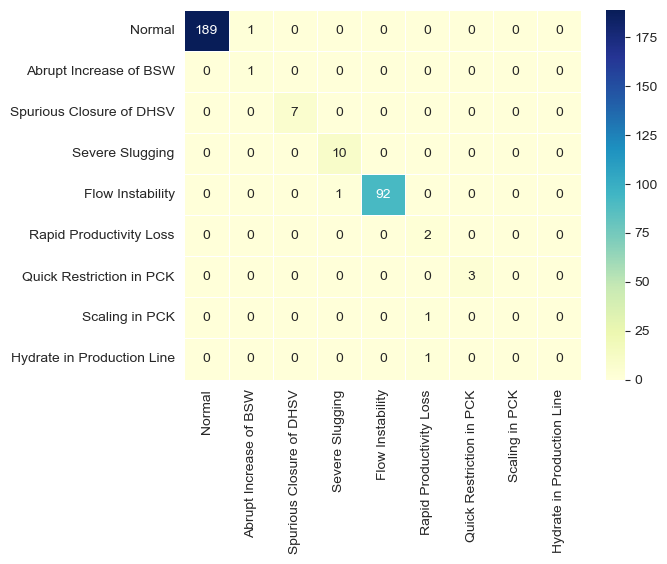

In [250]:
from sklearn.metrics import confusion_matrix
labels = [events_names[n] for n in list(set(instances.loc[list(set(X_test_raw['instance_id']))]['class_code']))]
conf_m = confusion_matrix(df_class['True'] , df_class['Pred'] )
sns.heatmap(
    conf_m,xticklabels= labels, yticklabels=labels,
    linewidths=.5, annot=True, cmap = "YlGnBu",fmt="d")
plt.savefig('test_results.png',bbox_inches = 'tight')
plt.show()

In [246]:
y_pred = RF_model.predict(X_train)
colums_class = ['True', 'Pred']
df_class = pd.DataFrame(columns=colums_class)
df_class['True'] = y_train
df_class['Pred'] = y_pred
precision, recall, f1, _ = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')

# print('{:>10} : {:.2f}'.format( 'accuracy', accuracy ) )
print('{:>10} : {:.3f}'.format( 'precision', np.average(precision) ) )
print('{:>10} : {:.3f}'.format( 'recall', np.average(recall) ) )
print('{:>10} : {:.3f}'.format( 'f1', np.average(f1) ) )

 precision : 0.999
    recall : 0.999
        f1 : 0.999


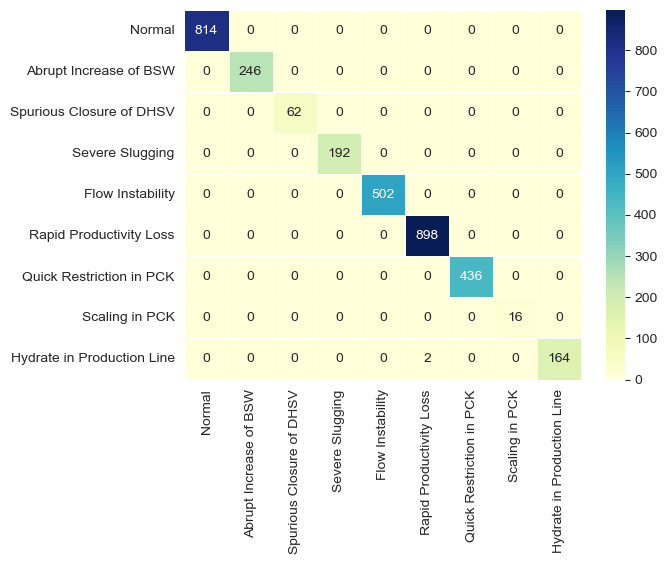

In [247]:
from sklearn.metrics import confusion_matrix
labels = [events_names[n] for n in list(set(instances.loc[list(set(X_test_raw['instance_id']))]['class_code']))]
conf_m = confusion_matrix(df_class['True'] , df_class['Pred'] )
sns.heatmap(
    conf_m,xticklabels= labels, yticklabels=labels,
    linewidths=.5, annot=True, cmap = "YlGnBu",fmt="d")
plt.savefig('train_results.png',bbox_inches = 'tight')
plt.show()

#### XGBoost classifier with Bayesian optimization

In [ ]:
print(f1)

In [252]:
import xgboost as xgb

def XGB_cv(max_depth,learning_rate, n_estimators, gamma
         ,min_child_weight, subsample
         ,colsample_bytree, ):

  # 모델 정의
    model = xgb.XGBClassifier(max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        )

      # 모델 훈련
    model.fit(X_train, y_train)

      # 예측값 출력
    y_pred= model.predict(X_test)
    colums_class = ['True', 'Pred']
    df_class = pd.DataFrame(columns=colums_class)
    df_class['True'] = y_test
    df_class['Pred'] = y_pred
    precision, recall, f1, _ = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')
    return np.average(f1)

pbounds = {'max_depth': (3, 7),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (50, 500),
                'gamma': (0, 100),
                'min_child_weight': (0, 3),
                'subsample': (0.5, 1),
                'colsample_bytree' :(0.2, 1)
                }

BO_x = BayesianOptimization(f= XGB_cv, pbounds=pbounds, verbose=2, random_state=1)
acquisition_function = UtilityFunction(kind='ei', xi=0.01)
BO_x.maximize(init_points=5, n_iter=20, acquisition_function=acquisition_function)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9448    | 0.5336    | 72.03     | 0.01002   | 4.209     | 0.4403    | 91.55     | 0.5931    |
| 2         | 0.9448    | 0.4764    | 39.68     | 0.1124    | 4.677     | 2.056     | 142.0     | 0.9391    |
| 3         | 0.9481    | 0.2219    | 67.05     | 0.08929   | 5.235     | 0.4212    | 139.1     | 0.9004    |
| 4         | 0.9416    | 0.9746    | 31.34     | 0.1415    | 6.506     | 2.684     | 88.27     | 0.5195    |
| 5         | 0.9416    | 0.3359    | 87.81     | 0.02869   | 4.684     | 2.874     | 289.9     | 0.8459    |
| 6         | 0.9448    | 0.4341    | 66.51     | 0.1824    | 4.402     | 1.019     | 139.8     | 0.6606    |
| 7         | 0.9481    | 0.3755    | 67.62     | 0.02322   | 3.554     | 0.1768    | 138.9     | 0.7127    |
| 8       

In [253]:
# params_opt = BO_x.max['params']
params_opt= {'max_depth': 3,
                'learning_rate': 0.2,
                'n_estimators': 5000,
                'gamma': 1,
                'min_child_weight': 2,
                'subsample': 0.5,
                'colsample_bytree' :0.2
                }

model = xgb.XGBClassifier(max_depth=int(params_opt['max_depth']),
    learning_rate=params_opt['learning_rate'],
    n_estimators=int(params_opt['n_estimators']),
    gamma=params_opt['gamma'],
    min_child_weight=params_opt['min_child_weight'],
    subsample=params_opt['subsample'],
    colsample_bytree=params_opt['colsample_bytree'],
    nthread=1
    )
  # 모델 훈련
model.fit(X_train, y_train)

  # 예측값 출력
y_pred= model.predict(X_test)
colums_class = ['True', 'Pred']
df_class = pd.DataFrame(columns=colums_class)
df_class['True'] = y_test
df_class['Pred'] = y_pred
precision, recall, f1, _ = precision_recall_fscore_support( df_class['True'], df_class['Pred'])

# print('{:>10} : {:.2f}'.format( 'accuracy', accuracy ) )
print('{:>10} : {:.2f}'.format( 'precision', np.average(precision) ) )
print('{:>10} : {:.2f}'.format( 'recall', np.average(recall) ) )
print('{:>10} : {:.2f}'.format( 'f1', np.average(f1) ) )

 precision : 0.71
    recall : 0.70
        f1 : 0.67


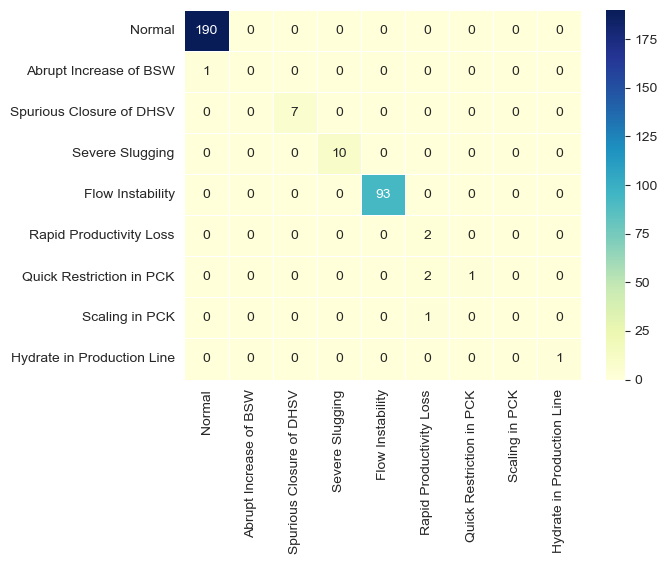

In [254]:
from sklearn.metrics import confusion_matrix
labels = [events_names[n] for n in list(set(instances.loc[list(set(X_test_raw['instance_id']))]['class_code']))]
conf_m = confusion_matrix(df_class['True'] , df_class['Pred'] )
sns.heatmap(
    conf_m,xticklabels= labels, yticklabels=labels,
    linewidths=.5, annot=True, cmap = "YlGnBu",fmt="d")
plt.savefig('train_results.png')
plt.show()

train (sim+hand) 100%+모자라면 real로 채워서 전체의 80%
test 나머지 real

In [155]:
test_ratio = 0.15
num_id = len(set(df_instances_clean['instance_id']))
num_test = int(test_ratio * num_id)
num_train = num_id - num_test
train_real = (num_train - len(synthetic_id))
test_ratio_real = round(1 - train_real / len(real_id),2)
print(f'num of train: {num_train}\nnum of test: {num_test}\nrequired real data for training dataset: {num_train - len(synthetic_id)}\ntest ratio in the real dataset: {test_ratio_real}')

num of train: 1687
num of test: 297
required real data for training dataset: 728
test ratio in the real dataset: 0.29


In [ ]:
# X_train_id, X_test_id, y_train, y_test = train_test_split(synthetic_id, synthetic_class, test_size=test_ratio, random_state=15)
# X_train_id_syn, X_test_id_syn, y_train_syn, y_test_syn = np.array(X_train_id), np.array(X_test_id), np.array(y_train), np.array(y_test)
X_train_id_syn, y_train_syn = np.array(synthetic_id), np.array(synthetic_class)
X_train_id_real, X_test_id, y_train_real, y_test = train_test_split(real_id, real_class, test_size=test_ratio_real, random_state=15)
X_train_id_real, X_test_id, y_train_real, y_test = np.array(X_train_id_real), np.array(X_test_id_real), np.array(y_train_real), np.array(y_test_real)

X_train_id = np.concatenate([X_train_id_syn, X_train_id_real])
y_train = np.concatenate([y_train_syn, y_train_real])

# class modification for binary classification
y_train[y_train!=0] = 1
y_test[y_test!=0] = 1

X_train = pd.DataFrame()
X_test = pd.DataFrame()
for id in X_train_id:
    X_train = pd.concat([X_train, df_instances_clean[df_instances_clean['instance_id'] == id]], axis=0).reset_index(drop=True)
for id in X_test_id:
    X_test = pd.concat([X_test, df_instances_clean[df_instances_clean['instance_id'] == id]], axis=0).reset_index(drop=True)

X_train_raw = X_train.drop(['class', 'source'], axis=1)
X_test_raw = X_test.drop(['class', 'source'], axis=1)

In [ ]:
X_train = extract_features(X_train_raw, column_id='instance_id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=disable_progressbar)

X_test = extract_features(X_test_raw, column_id='instance_id', column_sort='timestamp', default_fc_parameters=df_fc_p, impute_function=impute, n_jobs=0, disable_progressbar=disable_progressbar)
print(f'X_train: {len(X_train)}\ny_train: {len(y_train)}\nX_test: {len(X_test)}\ny_test: {len(y_test)}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.metrics import precision_recall_fscore_support

hyper = {'n_estimators':(50,500), 'max_depth':(5, 20), 'min_samples_leaf':(2,16), 'min_samples_split':(2,16)}
hyper_type = round

def objective(n_estimators, max_depth, min_samples_leaf, min_samples_split):
    for param in hyper.keys():
        hyper[param] = hyper_type(eval(param))
    RF_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                     max_depth=int(max_depth),
                                     min_samples_leaf=int(min_samples_leaf),
                                     min_samples_split=int(min_samples_split),
                                     random_state=0)
    RF_model.fit(X_train, y_train)
    y_pred = RF_model.predict(X_test)
    colums_class = ['True', 'Pred']
    df_class = pd.DataFrame(columns=colums_class)
    df_class['True'] = y_test
    df_class['Pred'] = y_pred
    ret = precision_recall_fscore_support(df_class['True'], df_class['Pred'], average='micro')
    p, r, f1, _ = ret
    return np.average(f1)

BO = BayesianOptimization(f= objective, pbounds=hyper)
acquisition_function = UtilityFunction(kind='ei', xi=0.0001)
BO.maximize(init_points=5, n_iter=20, acquisition_function=acquisition_function)

In [ ]:
params_opt = {}
for param in BO.max['params'].keys():
    params_opt[param] = round(BO.max['params'][param])

RF_model = RandomForestClassifier(n_estimators=params_opt['n_estimators'],
                                     max_depth=params_opt['max_depth'],
                                     min_samples_leaf=params_opt['min_samples_leaf'],
                                     min_samples_split=params_opt['min_samples_split'],
                                     random_state=0)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
colums_class = ['True', 'Pred']
df_class = pd.DataFrame(columns=colums_class)
df_class['True'] = y_test
df_class['Pred'] = y_pred
precision, recall, f1, _ = precision_recall_fscore_support( df_class['True'], df_class['Pred'])

# print('{:>10} : {:.2f}'.format( 'accuracy', accuracy ) )
print('{:>10} : {:.2f}'.format( 'precision', np.average(precision) ) )
print('{:>10} : {:.2f}'.format( 'recall', np.average(recall) ) )
print('{:>10} : {:.2f}'.format( 'f1', np.average(f1) ) )